In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
import time

In [2]:
def read_matrices_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Extract the matrix dimension from the first line
    dimension = int(lines[0].strip())

    # Initialize matrices and a temporary list to store the current row
    matrix1 = []
    matrix2 = []
    current_matrix = matrix1
    row = []

    # Start from the second line since the first line is the dimension
    for line in lines[1:]:
        # Split the line into numbers
        numbers = [int(num) for num in line.split()]

        # Append numbers to the current row, switch to a new row or matrix if needed
        for num in numbers:
            row.append(num)
            if len(row) == dimension:  # Row is complete
                current_matrix.append(row)
                row = []
                # Check if the current matrix is complete and switch to the next one
                if len(current_matrix) == dimension:
                    current_matrix = matrix2

    return matrix1, matrix2

In [3]:
instance_name = "nug12.dat" # Name of the instance
A, B = read_matrices_from_file(instance_name) # Extract Matrices
optimal = 578 # Optimal Value
N = len(A)  # Number of assignments/locations

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-14
Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24 rows, 144 columns and 288 nonzeros
Model fingerprint: 0x86746bc9
Model has 5940 quadratic objective terms
Variable types: 0 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 806.0000000
Presolve time: 0.05s
Presolved: 24 rows, 144 columns, 288 nonzeros
Presolved model has 6084 quadratic objective terms
Variable types: 0 continuous, 144 integer (144 binary)

Root relaxation: objecti

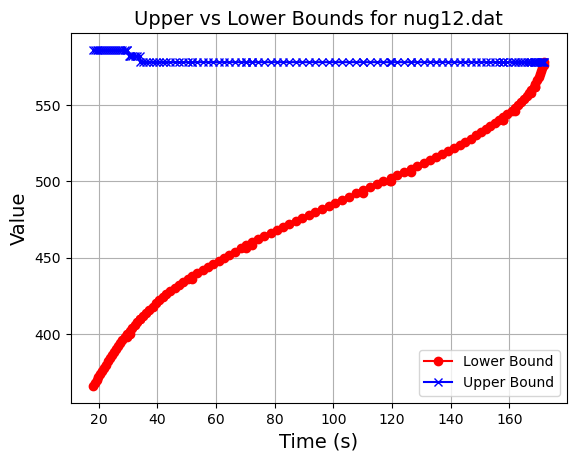

######################################## nug12.dat ########################################
GAP: 0.00%
Upper Bound: 578.0
##########################################################################################



In [4]:
m = gp.Model('QAP_Model')
m.setParam('TimeLimit', 600)
m.setParam('OutputFlag', 1)

# Callback function to record objective bounds
def data_cb(model, where):
    if where == gp.GRB.Callback.MIP:
        cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])

# Create variables
x = m.addVars(N, N, vtype=gp.GRB.BINARY, name="x")

# Objective function
obj = gp.quicksum(A[i][j] * B[p][q] * x[i, p] * x[j, q] for i in range(N) for j in range(N) for p in range(N) for q in range(N))
m.setObjective(obj, gp.GRB.MINIMIZE)

# Constraints
m.addConstrs((x.sum(i, '*') == 1 for i in range(N)), "AssignToLocation")
m.addConstrs((x.sum('*', j) == 1 for j in range(N)), "LocationAssigned")

# Initialize tracking variables
m._obj = None
m._bd = None
m._data = []
m._start = time.time()

# Optimize the model with the callback
m.optimize(data_cb)

# Plots
upper = []
lower = []
time_lst = []
for item in m._data[int(len(m._data) / 2):]:
    time_lst.append(item[0])
    upper.append(item[1])
    lower.append(item[2])

# Plotting bounds over time
plt.figure()
plt.plot(time_lst, lower, color='red', marker='o', label="Lower Bound")
plt.plot(time_lst, upper, color='blue', marker='x', label="Upper Bound")
plt.title(f'Upper vs Lower Bounds for {instance_name}', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.grid(True)

# Display plot
plt.show()

# Print results
print(f"######################################## {instance_name} ########################################")
if optimal != 0:
    gap = ((upper[-1] - optimal) / optimal) * 100
    print(f"GAP: {gap:.2f}%")
    print(f"Upper Bound: {upper[-1]}")
else:
    print(f"Instance with optimal value 0: {instance_name}")
print("##########################################################################################\n")